<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day6_of_MAGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install --user scprep
!pip install scprep
!pip install tensorflow==1.12.0

     |████████████████████████████████| 102kB 2.5MB/s 
     |████████████████████████████████| 83.1MB 89kB/s 
     |████████████████████████████████| 3.1MB 41.0MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [3]:
#import scprep
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import sklearn.manifold
import h5py
import pandas as pd
import scprep
import os
import sys
import seaborn as sns
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, 

In [0]:
################################################################
################################################################
# helper functions and model architecture
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak * x)

def nameop(op, name):
    op = tf.identity(op, name=name)
    return op

def tbn(name):
    return tf.get_default_graph().get_tensor_by_name(name)

def obn(name):
    return tf.get_default_graph().get_operation_by_name(name)

class MAGAN(object):
    def __init__(self,
        dim_b1,
        dim_b2,
        correspondence_loss,
        activation=lrelu,
        learning_rate=.001,
        restore_folder='',
        limit_gpu_fraction=1.,
        no_gpu=False,
        nfilt=64):
        self.dim_b1 = dim_b1
        self.dim_b2 = dim_b2
        self.correspondence_loss = correspondence_loss
        self.activation = activation
        self.learning_rate = learning_rate
        self.iteration = 0

        if restore_folder:
            self._restore(restore_folder)
            return

        self.xb1 = tf.placeholder(tf.float32, shape=[None, self.dim_b1], name='xb1')
        self.xb2 = tf.placeholder(tf.float32, shape=[None, self.dim_b2], name='xb2')

        self.lr = tf.placeholder(tf.float32, shape=[], name='lr')
        self.is_training = tf.placeholder(tf.bool, shape=[], name='is_training')

        self._build()
        self.init_session(limit_gpu_fraction=limit_gpu_fraction, no_gpu=no_gpu)
        self.graph_init(self.sess)

    def init_session(self, limit_gpu_fraction=.4, no_gpu=False):
        if no_gpu:
            config = tf.ConfigProto(device_count={'GPU': 0})
            self.sess = tf.Session(config=config)
        elif limit_gpu_fraction:
            gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=limit_gpu_fraction)
            config = tf.ConfigProto(gpu_options=gpu_options)
            self.sess = tf.Session(config=config)
        else:
            self.sess = tf.Session()

    def graph_init(self, sess=None):
        if not sess: sess = self.sess

        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

        sess.run(tf.global_variables_initializer())

        return self.saver

    def save(self, iteration=None, saver=None, sess=None, folder=None):
        if not iteration: iteration = self.iteration
        if not saver: saver = self.saver
        if not sess: sess = self.sess
        if not folder: folder = self.save_folder

        savefile = os.path.join(folder, 'MAGAN')
        saver.save(sess, savefile, write_meta_graph=True)
        print("Model saved to {}".format(savefile))

    def _restore(self, restore_folder):
        tf.reset_default_graph()
        self.init_session()
        ckpt = tf.train.get_checkpoint_state(restore_folder)
        self.saver = tf.train.import_meta_graph('{}.meta'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.sess, ckpt.model_checkpoint_path)
        print("Model restored from {}".format(restore_folder))

    def _build(self):
        self.G12 = Generator(self.dim_b2, name='G12')
        self.Gb2 = self.G12(self.xb1)
        self.Gb2 = nameop(self.Gb2, 'Gb2')

        self.G21 = Generator(self.dim_b1, name='G21')
        self.Gb1 = self.G21(self.xb2)
        self.Gb1 = nameop(self.Gb1, 'Gb1')

        self.xb2_reconstructed = self.G12(self.Gb1, reuse=True)
        self.xb1_reconstructed = self.G21(self.Gb2, reuse=True)
        self.xb1_reconstructed = nameop(self.xb1_reconstructed, 'xb1_reconstructed')
        self.xb2_reconstructed = nameop(self.xb2_reconstructed, 'xb2_reconstructed')

        self.D1 = Discriminator(name='D1')
        self.D2 = Discriminator(name='D2')

        self.D1_probs_z = self.D1(self.xb1)
        self.D1_probs_G = self.D1(self.Gb1, reuse=True)

        self.D2_probs_z = self.D2(self.xb2)
        self.D2_probs_G = self.D2(self.Gb2, reuse=True)

        self.D1_probs_xrecon = self.D2(self.xb1_reconstructed, reuse=True)
        self.D2_probs_xrecon = self.D2(self.xb2_reconstructed, reuse=True)

        self._build_loss()

        self._build_optimization()

    def _build_loss(self):
        self._build_loss_D()
        self._build_loss_G()
        self.loss_D = nameop(self.loss_D, 'loss_D')
        self.loss_G = nameop(self.loss_G, 'loss_G')
        tf.add_to_collection('losses', self.loss_D)
        tf.add_to_collection('losses', self.loss_G)

    def _build_loss_D(self):
        losses = []
        # the true examples
        losses.append(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D1_probs_z, labels=tf.ones_like(self.D1_probs_z))))
        losses.append(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D2_probs_z, labels=tf.ones_like(self.D2_probs_z))))
        # the generated examples
        losses.append(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D1_probs_G, labels=tf.zeros_like(self.D1_probs_G))))
        losses.append(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D2_probs_G, labels=tf.zeros_like(self.D2_probs_G))))
        self.loss_D = tf.reduce_mean(losses)

    def _build_loss_G(self):
        losses = []
        # fool the discriminator losses
        losses.append(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D1_probs_G, labels=tf.ones_like(self.D1_probs_G))))
        losses.append(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D2_probs_G, labels=tf.ones_like(self.D2_probs_G))))
        # reconstruction losses
        losses.append(10 * tf.reduce_mean((self.xb1 - self.xb1_reconstructed)**2))
        losses.append(10 * tf.reduce_mean((self.xb2 - self.xb2_reconstructed)**2))
        # correspondences losses
        losses.append(10 * tf.reduce_mean(self.correspondence_loss(self.xb1, self.Gb2)))
        losses.append(10 * tf.reduce_mean(self.correspondence_loss(self.xb2, self.Gb1)))

        self.loss_G = tf.reduce_mean(losses)

    def _build_optimization(self):
        Gvars = [tv for tv in tf.global_variables() if 'G12' in tv.name or 'G21' in tv.name]
        Dvars = [tv for tv in tf.global_variables() if 'D1' in tv.name or 'D2' in tv.name]

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        G_update_ops = [op for op in update_ops if 'G12' in op.name or 'G21' in op.name]
        D_update_ops = [op for op in update_ops if 'D1' in op.name or 'D2' in op.name]

        with tf.control_dependencies(G_update_ops):
            optG = tf.train.AdamOptimizer(self.lr, beta1=.5, beta2=.99)
            self.train_op_G = optG.minimize(self.loss_G, var_list=Gvars, name='train_op_G')

        with tf.control_dependencies(D_update_ops):
            optD = tf.train.AdamOptimizer(self.lr, beta1=.5, beta2=.99)
            self.train_op_D = optD.minimize(self.loss_D, var_list=Dvars, name='train_op_D')

    def train(self, xb1, xb2):
        self.iteration += 1

        feed = {tbn('xb1:0'): xb1,
                tbn('xb2:0'): xb2,
                tbn('lr:0'): self.learning_rate,
                tbn('is_training:0'): True}

        _ = self.sess.run([obn('train_op_G')], feed_dict=feed)
        _ = self.sess.run([obn('train_op_D')], feed_dict=feed)

    def get_layer(self, xb1, xb2, name):
        tensor_name = "{}:0".format(name)
        tensor = tbn(tensor_name)

        feed = {tbn('xb1:0'): xb1,
                tbn('xb2:0'): xb2,
                tbn('is_training:0'): False}

        layer = self.sess.run(tensor, feed_dict=feed)

        return layer

    def get_loss_names(self):
        losses = [tns.name[:-2].replace('loss_', '').split('/')[-1] for tns in tf.get_collection('losses')]
        return "Losses: {}".format(' '.join(losses))

    def get_loss(self, xb1, xb2):
        feed = {tbn('xb1:0'): xb1,
                tbn('xb2:0'): xb2,
                tbn('is_training:0'): False}

        ls = [tns for tns in tf.get_collection('losses')]
        losses = self.sess.run(ls, feed_dict=feed)

        lstring = ' '.join(['{:.3f}'.format(loss) for loss in losses])

        return lstring


class Generator(object):

    def __init__(self,
        output_dim,
        name='',
        activation=lrelu):
        self.output_dim = output_dim
        self.activation = activation
        self.name = name

    def __call__(self, x, reuse=False):
        with tf.variable_scope(self.name):
            h1 = tf.layers.dense(x, 200, activation=self.activation, reuse=reuse, name='h1')
            h2 = tf.layers.dense(h1, 100, activation=self.activation, reuse=reuse, name='h2')
            h3 = tf.layers.dense(h2, 50, activation=self.activation, reuse=reuse, name='h3')

            out = tf.layers.dense(h3, self.output_dim, activation=None, reuse=reuse, name='out')

        return out + x

class Discriminator(object):
    def __init__(self,
        name='',
        activation=lrelu):
        self.activation = activation
        self.name = name

    def __call__(self, x, reuse=False):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            h1 = tf.layers.dense(x, 100, activation=self.activation, reuse=reuse, name='h1')
            h2 = tf.layers.dense(h1, 50, activation=self.activation, reuse=reuse, name='h2')
            h3 = tf.layers.dense(h2, 25, activation=self.activation, reuse=reuse, name='h3')
            out = tf.layers.dense(h3, 1, activation=None, reuse=reuse, name='out')

        return out





class Loader(object):
    def __init__(self, data, labels=None, shuffle=False):
        self.start = 0
        self.epoch = 0
        self.data = [x for x in [data, labels] if x is not None]
        self.labels_given = False if labels is None else True

        if shuffle:
            self.r = list(range(data.shape[0]))
            np.random.shuffle(self.r)
            self.data = [x[self.r] for x in self.data]

    def next_batch(self, batch_size=100):
        num_rows = self.data[0].shape[0]

        if self.start + batch_size < num_rows:
            batch = [x[self.start:self.start + batch_size] for x in self.data]
            self.start += batch_size
        else:
            self.epoch += 1
            batch_part1 = [x[self.start:] for x in self.data]
            batch_part2 = [x[:batch_size - (x.shape[0] - self.start)] for x in self.data]
            batch = [np.concatenate([x1, x2], axis=0) for x1, x2 in zip(batch_part1, batch_part2)]

            self.start = batch_size - (num_rows - self.start)

        if not self.labels_given:  # don't return length-1 list
            return batch[0]
        else:  # return list of data and labels
            return batch

    def iter_batches(self, batch_size=100):
        num_rows = self.data[0].shape[0]

        start = 0
        end = batch_size

        for i in range(num_rows // batch_size):
            start = i * batch_size
            end = (i + 1) * batch_size

            if not self.labels_given:
                yield [x[start:end] for x in self.data][0]
            else:
                yield [x[start:end] for x in self.data]

        if batch_size > num_rows:
            if not self.labels_given:
                yield [x for x in self.data][0]
            else:
                yield [x for x in self.data]
        if end != num_rows:
            if not self.labels_given:
                yield [x[end:] for x in self.data][0]
            else:
                yield [x[end:] for x in self.data]


################################################################
################################################################

In [0]:
################################################################
################################################################
# download and load data
scprep.io.download.download_google_drive("1ldIXV-RyY4cgu90L51NmRV8js3rsIA-B", "shekhar_two_batches.zip")
scprep.io.download.unzip("shekhar_two_batches.zip")

with open('shekhar_two_batches.npz', 'rb') as f:
    npzfile = np.load(f)
    xb1 = npzfile['x1']
    xb2 = npzfile['x2']


# use the handy little loader class
# in training: get random order
# to evaluate: get same order, so we know which row is which
loadtrain1 = Loader(xb1, shuffle=True)
loadtrain2 = Loader(xb2, shuffle=True)
loadeval1 = Loader(xb1, shuffle=False)
loadeval2 = Loader(xb2,shuffle=False)
################################################################
################################################################

In [0]:
################################################################
################################################################
# the function that takess in two tensorflow matrices
# and returns the loss between the two domain spaces
def correspondence_loss(b1, b2):
    loss =  tf.reduce_mean((b1 - b2)**2)

    return loss
################################################################
################################################################

In [0]:
################################################################
################################################################
# Build the tf graph
batch_size = 100
tf.reset_default_graph()
magan = MAGAN(dim_b1=xb1.shape[1], dim_b2=xb2.shape[1], correspondence_loss=correspondence_loss)
################################################################
################################################################

Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Losses: D G 0.147 3.047
Iter 600
Iter 700
Iter 800
Iter 900
Iter 1000
Losses: D G 0.150 3.525
Iter 1100
Iter 1200
Iter 1300
Iter 1400
Iter 1500
Losses: D G 0.135 3.760
Iter 1600
Iter 1700
Iter 1800
Iter 1900


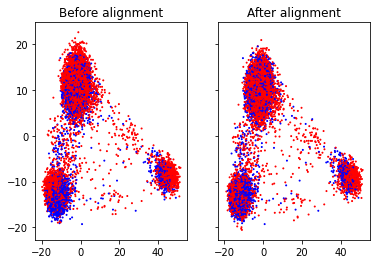

In [8]:
################################################################
################################################################
# Train
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
for i in range(1, 2000):
    if i % 100 == 0: print("Iter {}".format(i))
    xb1_ = loadtrain1.next_batch(batch_size)
    xb2_ = loadtrain2.next_batch(batch_size)

    magan.train(xb1_, xb2_)
    

    # Evaluate the loss and plot
    if i % 500 == 0:

        lstring = magan.get_loss(xb1_, xb2_)
        print("{} {}".format(magan.get_loss_names(), lstring))

        fig.clf()
        axes = fig.subplots(1, 2, sharex=True, sharey=True)
        Gb1 = magan.get_layer(xb1, xb2, 'Gb1')
        Gb2 = magan.get_layer(xb1, xb2, 'Gb2')

        pca1 = sklearn.decomposition.PCA(2)
        out1 = pca1.fit_transform(np.concatenate([xb1, xb2], axis=0))
        out2 = pca1.transform(np.concatenate([xb1, Gb1], axis=0))
        c = np.concatenate([np.zeros(xb1.shape[0]), np.ones(xb2.shape[0])], axis=0)
        r = np.random.choice(c.shape[0], c.shape[0], replace=False)

        
        axes[0].set_title('Before alignment')
        axes[1].set_title('After alignment')
        axes[0].scatter(out1[r, 0], out1[r, 1], s=1, c=c[r], cmap=mpl.cm.bwr)
        axes[1].scatter(out2[r, 0], out2[r, 1], s=1, c=c[r], cmap=mpl.cm.bwr)
        fig.canvas.draw()
################################################################
################################################################

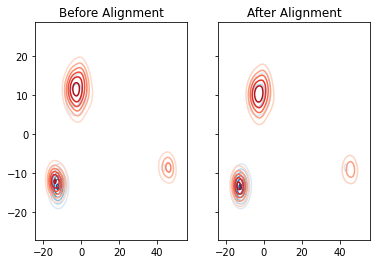

In [9]:
################################################################
################################################################
# show output with KDE plot to see density
Gb1 = magan.get_layer(xb1, xb2, 'Gb1')
Gb2 = magan.get_layer(xb1, xb2, 'Gb2')

pca1 = sklearn.decomposition.PCA(2)
out1 = pca1.fit_transform(np.concatenate([xb1, xb2], axis=0))
out2 = pca1.transform(np.concatenate([xb1, Gb1], axis=0))
c = np.concatenate([np.zeros(xb1.shape[0]), np.ones(xb2.shape[0])], axis=0)
r = np.random.choice(c.shape[0], c.shape[0], replace=False)


fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].set_title('Before Alignment')
axes[1].set_title('After Alignment')
sns.kdeplot(out1[:xb1.shape[0], 0], out1[:xb1.shape[0], 1], ax=axes[0], n_levels=6, cmap='Blues')
sns.kdeplot(out1[xb1.shape[0]:, 0], out1[xb1.shape[0]:, 1], ax=axes[0], n_levels=6, cmap='Reds')

sns.kdeplot(out2[:xb1.shape[0], 0], out2[:xb1.shape[0], 1], ax=axes[1], n_levels=6, cmap='Blues')
sns.kdeplot(out2[xb1.shape[0]:, 0], out2[xb1.shape[0]:, 1], ax=axes[1], n_levels=6, cmap='Reds')
################################################################
################################################################


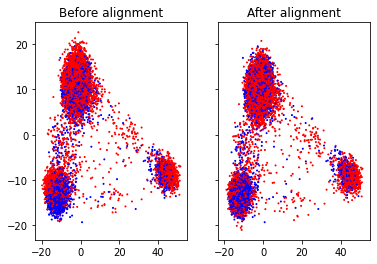

In [10]:
################################################################
################################################################
# scatter: not as informative as KDE plot
# (this is misleading, can't see density and overemphasizes outliers)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
Gb1 = magan.get_layer(xb1, xb2, 'Gb1')
Gb2 = magan.get_layer(xb1, xb2, 'Gb2')

pca1 = sklearn.decomposition.PCA(2)
out1 = pca1.fit_transform(np.concatenate([xb1, xb2], axis=0))
out2 = pca1.transform(np.concatenate([xb1, Gb1], axis=0))
c = np.concatenate([np.zeros(xb1.shape[0]), np.ones(xb2.shape[0])], axis=0)
r = np.random.choice(c.shape[0], c.shape[0], replace=False)


axes[0].set_title('Before alignment')
axes[1].set_title('After alignment')
axes[0].scatter(out1[r, 0], out1[r, 1], s=1, c=c[r], cmap=mpl.cm.bwr)
axes[1].scatter(out2[r, 0], out2[r, 1], s=1, c=c[r], cmap=mpl.cm.bwr)
fig.canvas.draw()
################################################################
################################################################